**Import Packages & Load Data**

In [95]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python

import os

# Data formatting libraries
import numpy as np # Linear algebra
import pandas as pd # Data processing, CSV file I/O (e.g. pd.read_csv)
import math # Mathmatic functions (eg. sqrt())

# SKLearn data partitioning libraries
from sklearn.model_selection import train_test_split # Splits data into training and testing pools
from sklearn.model_selection import cross_val_score # Systematically portions data into pools for K-Folding

# Graphing libraries
import matplotlib.pyplot as plt # Basic data graphing and visualization
import seaborn as sns # Visualization library building on matplotlib toolset
if os.environ['HOME'] != '/tmp': # Turn on 'inline' if not within the kaggle kernel environment (ie. in Jupyter notebook) as kaggle pre-activates inline
    %matplotlib inline # Graph in notebook

df = pd.read_csv("../input/breast-cancer-wisconsin-data/data.csv", header = 0) # Data starts on the 2nd index of the spreadsheet

**Data Cleaning**

Before anything, the first and last columns of our dataframe ("id", "Unnamed: 32") aren't providing anything of value to us.  We'll drop those from the table to make things cleaner.

Let's also make sure that the data is being recognized as quantitative values (ie. floats, integers).

In [96]:
df.drop(["id","Unnamed: 32"],axis = 1,inplace = True)
df.info(null_counts = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
diagnosis                  569 non-null object
radius_mean                569 non-null float64
texture_mean               569 non-null float64
perimeter_mean             569 non-null float64
area_mean                  569 non-null float64
smoothness_mean            569 non-null float64
compactness_mean           569 non-null float64
concavity_mean             569 non-null float64
concave points_mean        569 non-null float64
symmetry_mean              569 non-null float64
fractal_dimension_mean     569 non-null float64
radius_se                  569 non-null float64
texture_se                 569 non-null float64
perimeter_se               569 non-null float64
area_se                    569 non-null float64
smoothness_se              569 non-null float64
compactness_se             569 non-null float64
concavity_se               569 non-null float64
concave points_se          569 n

Looks good - no missing values or unexpected datatypes.  The very first item in our dataset, 'diagnosis', has been encoded as M and B.  For the sake of clean coding, we will convert malignant cases to 1 and benign cases to 0.

With that all sorted let's also examine the fully-formatted dataframe.

In [97]:
df['diagnosis'] = df['diagnosis'].map({'M':1,'B':0})
df

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,...,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
1,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,...,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902
2,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,...,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758
3,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,...,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300
4,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,...,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,1,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,...,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,1,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,...,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,1,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,...,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,1,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,...,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400


In [98]:
# Dataframe column partitioning (title only, used for index referencing)
attribute_mean = df.columns[1:11]
attribute_se = df.columns[11:20]
attribute_error = df.columns[21:31]

# Dataframe is split into positive and negative cases for performing overlapped plotting
dfM = df[df['diagnosis'] == 1] # Dataframe containing only participants with malignant tumours
dfB = df[df['diagnosis'] == 0] # Dataframe containing only participants with benign tumours

# Final working variables, will be used 
X = np.array(df.drop(['diagnosis'], axis = 1))
y = np.array(df['diagnosis'])

**Visual Overview & Trends**

Now we start getting into the actual modelling.  Let's first look at the ratio of 'Malignant' to 'Benign' diagnoses.

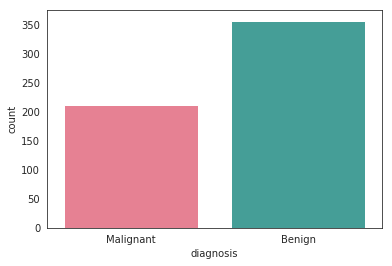

In [99]:
# Graph styling
sns.set_style("white")
sns.countplot(df['diagnosis'].map({1:'Malignant', 0:'Benign'}), palette = "husl")
plt.show()

In [1]:
# Graphing
bins = 12
plt.figure(figsize=(32,9))
for i, feature in enumerate(attribute_mean):
    cols = int(len(attribute_mean) / 2)
    
    #plt.subplot(rows, 2, i+1)
    plt.subplot(2, cols, i+1)
    
    sns.distplot(dfM[feature], bins=bins, color = 'r', label = 'M');
    sns.distplot(dfB[feature], bins=bins, color = '#69E71C', label = 'B');
    
    plt.legend(loc='upper right')
    
plt.show()

NameError: name 'plt' is not defined

In [2]:
# Alternative graphing approach

# fig, axes = plt.subplots(nrows = 2, ncols = 5, figsize = (32, 9))
# axes = axes.ravel()
# for idx, ax in enumerate(axes):
#     ax.figure
#     binwidth = (max(df[attribute_mean[idx]]) - min(df[attribute_mean[idx]])) / 50
#     #ax.hist(dfB[attribute_mean[idx]], bins=np.arange(min(df[attribute_mean[idx]]), max(df[attribute_mean[idx]]) + binwidth, binwidth), alpha=0.5,stacked=True, label='B')
#     #ax.hist(dfM[attribute_mean[idx]], bins=np.arange(min(df[attribute_mean[idx]]), max(df[attribute_mean[idx]]) + binwidth, binwidth), alpha=0.5,stacked=True, label='M')
#     ax.hist([dfM[attribute_mean[idx]],dfB[attribute_mean[idx]]], 
#             bins = np.arange(min(df[attribute_mean[idx]]), max(df[attribute_mean[idx]]) + binwidth, binwidth),
#             alpha = 0.5,
#             stacked = True,
#             label = ['M','B'],
#             color = ['red', 'green'],
#             histtype = 'bar')
#     ax.legend(loc = 'upper right')
#     ax.set_title(attribute_mean[idx])
# plt.tight_layout()
# plt.show()

There appears to be a relationship between cell nucleus size and the status of tumor malignancy, such that larger values of these tissues' features are positively correlated with higher rates of a malignant diagnosis.

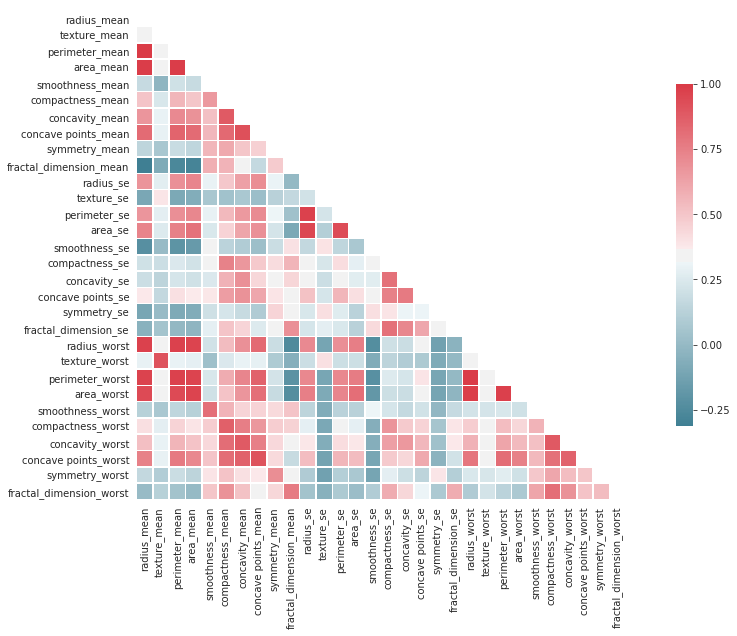

In [102]:
# Generate a mask for the upper triangle
mask = np.zeros_like((df.drop(['diagnosis'], axis = 1)).corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(18, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap((df.drop(['diagnosis'], axis = 1)).corr(), mask=mask, cmap=cmap,
            square=True, linewidths=.5, cbar_kws={"shrink": .7})

plt.show()

In [103]:
# Alternative Graphing

# f,ax = plt.subplots(figsize = (18, 18))
# sns.heatmap((df.drop(['diagnosis'], axis = 1)).corr(), annot= True, fmt = ".0%")
# plt.yticks(rotation = 0)
# plt.title('Attribute Correlation Heatmap')
# plt.show()

**Demonstrating Basic Sub-Sampling**

Before we can begin teaching our models anything, we have to split our dataset such that some portion of data will be used to train the model while the remaining is used to test it's accuracy later on -- kind of like if a professor were to provide practice questions so students can practice for the real test. 

In [104]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1)

print ("Total number of patients, features: ", X.shape)
print()
print("Independent training; number of patients, features: ", X_train.shape)
print("Independent testing; number of patients, features: ", X_test.shape)
print()
print("Dependent training; number of patient diagnoses: ", y_train.shape)
print("Dependent testing; number of patient diagnoses: ", y_test.shape)

Total number of patients, features:  (569, 30)

Independent training; number of patients, features:  (512, 30)
Independent testing; number of patients, features:  (57, 30)

Dependent training; number of patient diagnoses:  (512,)
Dependent testing; number of patient diagnoses:  (57,)


This shows the sample size of each variable pair.  So, the X.shape tells us that our original dataset contains 569 patients, each with 30 unique features describing their tumor.  To accumulate our 'test' sample, we're bootstrapping from 10% of the total patient pool, with our 'train' sample being comprised of the remaining 90%.  We can validate this by checking the shape of our variables:

Training: **569 * .90 = ~512**

Testing: **569 * .10 = ~57**

Because only our independent variables contain numerous features their data shape is two dimensional.  Dependent variables, however, only remain comprised only of a binary 'diagnosis' value for each.

While this method provides a quick and easy way to get underway with ML, there are more reliable sampling techniques we can utilize.  For the purposes of this notebook, we'll be using cross-validation.

**Performing K-Fold Cross Validation**

Similar to a test-train split, K-Fold Cross Validation works by segmenting the total dataset into segments.  However, it provides an added layer of reliability (K times more reliability, actually) by incorporating all sub-samples into both training and testing.  To robustly determine which model is providing the highest accuracy of classification, we'll perform a cross validation with 10 folds (K=10).  This means our total dataset will be segmented into 10 portions, with each being used to test the model trained from the other 9.  The only real disadvantage with this approach is computation time as it takes K times longer to calculate scores compared to a simple test_train_split.  Though, seeing as out dataset is relatively small, this isn't of substantial concern.

**1. Linear Regression**

To illustrate the contrast between these data sampling methods, we'll perform both on a logisitc regression model - first using a simple test_train_split, then performing it fully with cross validation.  We'll be employing cross validation to score accuracy in our ML models moving forward.

In [105]:
from sklearn.linear_model import LogisticRegression

Test-Train Split

In [106]:
logistic = LogisticRegression(max_iter = 3000, solver='lbfgs')
logistic.fit(X_train, y_train)
predictions = logistic.predict(X_test)

for i in range(len(predictions)):
    print (f"Prediction: {predictions[i]}, Actual: {y_test[i]}")
    
test_score = logistic.score(X_test, y_test)

print()
print(f"{test_score:.4%}")

Prediction: 0, Actual: 0
Prediction: 1, Actual: 1
Prediction: 0, Actual: 0
Prediction: 1, Actual: 1
Prediction: 1, Actual: 1
Prediction: 0, Actual: 0
Prediction: 0, Actual: 0
Prediction: 0, Actual: 0
Prediction: 1, Actual: 1
Prediction: 0, Actual: 0
Prediction: 0, Actual: 0
Prediction: 0, Actual: 0
Prediction: 0, Actual: 0
Prediction: 1, Actual: 0
Prediction: 0, Actual: 0
Prediction: 0, Actual: 0
Prediction: 0, Actual: 0
Prediction: 1, Actual: 1
Prediction: 0, Actual: 0
Prediction: 0, Actual: 0
Prediction: 1, Actual: 1
Prediction: 1, Actual: 0
Prediction: 0, Actual: 0
Prediction: 1, Actual: 1
Prediction: 0, Actual: 0
Prediction: 1, Actual: 1
Prediction: 0, Actual: 0
Prediction: 1, Actual: 1
Prediction: 0, Actual: 0
Prediction: 1, Actual: 1
Prediction: 0, Actual: 0
Prediction: 0, Actual: 1
Prediction: 0, Actual: 0
Prediction: 1, Actual: 1
Prediction: 0, Actual: 0
Prediction: 0, Actual: 0
Prediction: 0, Actual: 0
Prediction: 1, Actual: 1
Prediction: 1, Actual: 1
Prediction: 1, Actual: 0


Cross Validation (K-Fold = 10)

Fold #1: 98.276%
Fold #2: 91.379%
Fold #3: 92.982%
Fold #4: 94.737%
Fold #5: 98.246%
Fold #6: 98.246%
Fold #7: 92.982%
Fold #8: 94.643%
Fold #9: 96.429%
Fold #10: 96.429%
Logisitc Regression - model score: 95.435%


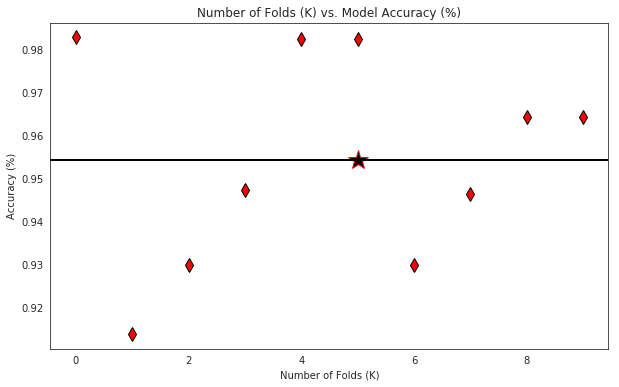

In [107]:
logistic = LogisticRegression(max_iter = 3000, solver='lbfgs')
logit_scores = cross_val_score(logistic, X, y, cv = 10, scoring = "accuracy") # We want accuracy reported here, rather than 'precision' or 'recall'

plt.figure(figsize=(10,6))
plt.plot(range(len(logit_scores)), logit_scores, color = 'none', linestyle = 'none', marker = 'd', markerfacecolor = 'red', markersize = 10) # Individual folds
plt.plot(len(logit_scores) / 2, logit_scores.mean(), color = 'red', linestyle = '-', marker = '*', markerfacecolor = 'black', markersize = 20) # Mean fold score
plt.axhline(logit_scores.mean(), linewidth = 2, color = 'black')  
plt.title('Number of Folds (K) vs. Model Accuracy (%)')
plt.xlabel('Number of Folds (K)')
plt.ylabel('Accuracy (%)')

for count, kf in enumerate(logit_scores, 1):
    print (f"Fold #{count}: {kf:.3%}")
print(f"Logisitc Regression - model score: {logit_scores.mean():.3%}") # Effectively, this is just a test_train_split performed 10 times, then scored as the mean accuracy of all runs.

For each of the models we test, we'll append its cross-validated score to a dictionary for full comparison later on.

In [108]:
MODEL_SCORES = {}

MODEL_SCORES.update({'Logisitic':logit_scores.mean()})

It's important to note that stronger accuracy scores != necessarily equal a model that is better at generalizing trends and identifiying them in new instances (ie. machine learning).  It is entirely possible to overfit a model to the data from which it 'learns'.  In cases where this occurs, the model has not so much identified consistent rates of attributable variability as it has latched onto the noise of the it's own particular training set.  This figure illustrates the phenomenon really well.

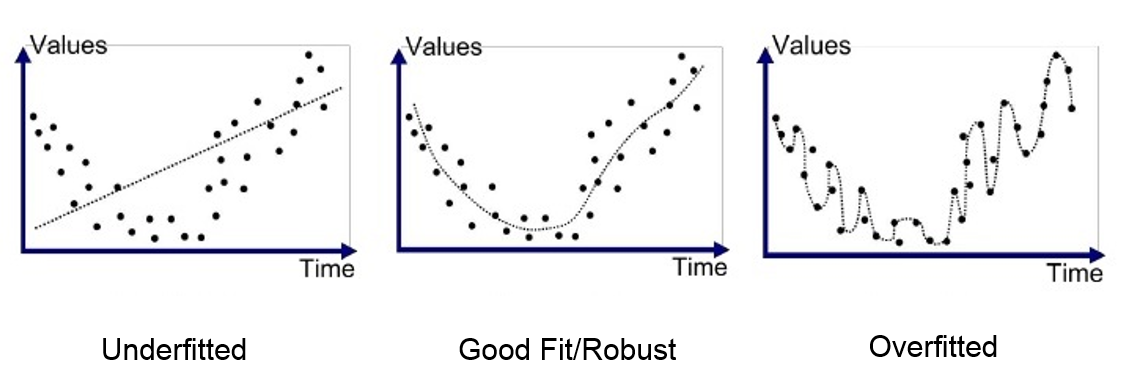

That's why a small amount of uncertainty is almost always desirable; if we're certain, we're not open to identify unseen possibilities of what we are, in fact, looking for.  Deep, eh?

**2. K-Nearest Neighbor (KNN)**

Even though this is only an introductory notebook, there are simple model variables we can play with.  In order to give each model a fair chance to demonstrate it's predicitive capacity for our data, we should make an effort to individually optimize parameters where necessary.  To determine the optimal K for our model; that is, the number of distinct clusters to which data can be grouped, we should loop through a number of groups to see which produces the strongest accuracy.

Some data scientists and statsticians propose that the square root of the total N generally provides a suitable out-of-the-box K parameter.  Let's check what that would be before investigating further.

In [109]:
print (f"Square root of N: {math.sqrt(X.shape[0]):.3f}")

Square root of N: 23.854


About 24.

To more thoroughly look at what K would work best with our KNN model, we'll iterate K through a range of 40.  Though 40 relatively arbitrary range, a K that is nearly double the size of the square root of N = 569 would be highly unexpected.  We'll also graph the model accuracy of each K parameter to visualize the contrast in performance.

In [110]:
from sklearn.neighbors import KNeighborsClassifier

Out-of-the-box accuracy: 92.8335%
Out-of-the-box clustering parameter (K): 24

Highest accuracy: 93.3505%
Optimal clustering parameter (K): 14


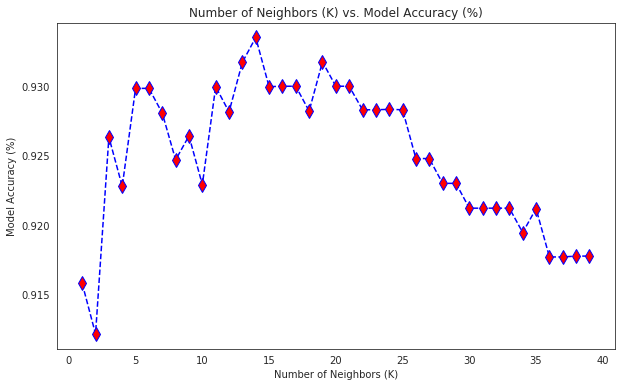

In [111]:
optimal_k = 0
score = []
for k in range(1,40):
    knn = KNeighborsClassifier(n_neighbors = k)
    knn_scores = cross_val_score(knn, X, y, cv = 10, scoring = "accuracy")
    if len(score) != 0:
        if knn_scores.mean() > max(score):
            optimal_k = k
    score.append(knn_scores.mean())

plt.figure(figsize=(10,6))
plt.plot(range(1,40), score, color='blue', linestyle='dashed', marker='d', markerfacecolor='red', markersize=10)
plt.title('Number of Neighbors (K) vs. Model Accuracy (%)')
plt.xlabel('Number of Neighbors (K)')
plt.ylabel('Model Accuracy (%)')

print (f"Out-of-the-box accuracy: {score[23]:.4%}")
print ("Out-of-the-box clustering parameter (K): 24")
print()
print (f"Highest accuracy: {max(score):.4%}")
print ("Optimal clustering parameter (K):", optimal_k)

Though not *substantially* more accuracte than the out-of-the-box sqrt() approach which provided around **K(24) = 92.88%** compared to our strongest **K(14) = 93.35%** model accuracy, it illustrates the benefits of taking a more comprehensive approach to optimizing.  Nevertheless, we can see that the model is a few percentage points lower in accuracy than the logisitic regression.

With that, let's run the model once more with the K = 14.

In [112]:
knn = KNeighborsClassifier(n_neighbors = optimal_k)
knn_scores = cross_val_score(knn, X, y, cv = 10, scoring = "accuracy")

for count, kf in enumerate(knn_scores, 1):
    print (f"Fold #{count}: {kf:.3%}")
print(f"KNN - model score: {knn_scores.mean():.3%}")

Fold #1: 87.931%
Fold #2: 86.207%
Fold #3: 91.228%
Fold #4: 96.491%
Fold #5: 96.491%
Fold #6: 94.737%
Fold #7: 96.491%
Fold #8: 96.429%
Fold #9: 91.071%
Fold #10: 96.429%
KNN - model score: 93.351%


In [113]:
MODEL_SCORES.update({'KNN':knn_scores.mean()})

**3. Support Vector Machine (SVM)**

In [114]:
from sklearn.svm import SVC

In [115]:
svm = SVC(kernel = 'linear')
svm_scores = cross_val_score(svm, X, y, cv = 10, scoring = "accuracy")

for count, kf in enumerate(svm_scores, 1):
    print (f"Fold #{count}: {kf:.3%}")
print(f"SVM - model score: {svm_scores.mean():.3%}")

Fold #1: 98.276%
Fold #2: 93.103%
Fold #3: 92.982%
Fold #4: 94.737%
Fold #5: 96.491%
Fold #6: 98.246%
Fold #7: 92.982%
Fold #8: 94.643%
Fold #9: 96.429%
Fold #10: 96.429%
SVM - model score: 95.432%


In [116]:
MODEL_SCORES.update({'SVM':svm_scores.mean()})

**4. Naïve Bayes**

In [117]:
from sklearn.naive_bayes import GaussianNB

In [118]:
nb = GaussianNB()
nb_scores = cross_val_score(nb, X, y, cv = 10, scoring = "accuracy")

for count, kf in enumerate(nb_scores, 1):
    print (f"Fold #{count}: {kf:.3%}")
print(f"Naïve Bayes - model score: {nb_scores.mean():.3%}")

Fold #1: 94.828%
Fold #2: 87.931%
Fold #3: 89.474%
Fold #4: 92.982%
Fold #5: 94.737%
Fold #6: 98.246%
Fold #7: 92.982%
Fold #8: 96.429%
Fold #9: 94.643%
Fold #10: 96.429%
Naïve Bayes - model score: 93.868%


In [119]:
MODEL_SCORES.update({'Naïve Bayes':nb_scores.mean()})

**5. Decision Tree**

In [120]:
from sklearn.tree import DecisionTreeClassifier

In [121]:
dtree = DecisionTreeClassifier()
dtree_scores = cross_val_score(dtree, X, y, cv = 10, scoring = "accuracy")

for count, kf in enumerate(dtree_scores, 1):
    print (f"Fold #{count}: {kf:.3%}")
print(f"Decision Tree - model score: {dtree_scores.mean():.3%}")

Fold #1: 93.103%
Fold #2: 86.207%
Fold #3: 92.982%
Fold #4: 91.228%
Fold #5: 94.737%
Fold #6: 91.228%
Fold #7: 87.719%
Fold #8: 94.643%
Fold #9: 92.857%
Fold #10: 94.643%
Decision Tree - model score: 91.935%


In [ ]:
MODEL_SCORES.update({'Decision Tree':dtree_scores.mean()})

**6. Random Forest**

In [122]:
from sklearn.ensemble import RandomForestClassifier

In [123]:
rforest = RandomForestClassifier(n_estimators = 50, warm_start = True)
rforest_scores = cross_val_score(rforest, X, y, cv = 10, scoring = "accuracy")

for count, kf in enumerate(rforest_scores, 1):
    print (f"Fold #{count}: {kf:.3%}")
print(f"Random Forest - model score: {rforest_scores.mean():.3%}")

Fold #1: 98.276%
Fold #2: 89.655%
Fold #3: 94.737%
Fold #4: 96.491%
Fold #5: 100.000%
Fold #6: 98.246%
Fold #7: 96.491%
Fold #8: 98.214%
Fold #9: 96.429%
Fold #10: 98.214%
Random Forest - model score: 96.675%


In [124]:
MODEL_SCORES.update({'Random Forest':rforest_scores.mean()})

**Model Performance Comparison**

AttributeError: Unknown property yticklabels

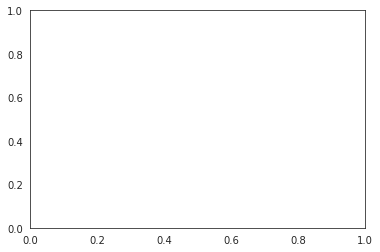

In [152]:
sns.countplot(list(MODEL_SCORES), palette = "husl", saturation = 1)
plt.xticks(rotation=45)
